## [Gaussian Mixture Model](http://pyro.ai/examples/gmm.html#Gaussian-Mixture-Model)

In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.2')

##### Pyro’s TraceEnum_ELBO can automatically marginalize out variables in both the guide and the model. When enumerating guide variables, Pyro can either enumerate sequentially (which is useful if the variables determine downstream control flow), or enumerate in parallel by allocating a new tensor dimension and using nonstandard evaluation to create a tensor of possible values at the variable’s sample site. These nonstandard values are then replayed in the model. When enumerating variables in the model, the variables must be enumerated in parallel and must not appear in the guide. Mathematically, guide-side enumeration simply reduces variance in a stochastic ELBO by enumerating all values, whereas model-side enumeration avoids an application of Jensen’s inequality by exactly marginalizing out a variable.

In [2]:
data = torch.tensor([0., 1., 10., 11., 12.])

##### Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. During inference, TraceEnum_ELBO will marginalize out the assignments of datapoints to clusters.

In [3]:
K = 2  # Fixed number of components.

In [4]:
@config_enumerate
def model(data):
    # Global Parameters
    weights = pyro.sample("weights", dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample("scale", dist.LogNormal(0., 2.))

    with pyro.plate("components", K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate("data", len(data)):
        # Local assignment
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

#####  Pyro’s config_enumerate() handler to enumerate over all assignments in each iteration. Since we’ve wrapped the batched Categorical assignments in a pyro.plate indepencence context, this enumeration can happen in parallel: we enumerate only 2 possibilites, rather than 2**len(data) = 32. Finally, to use the parallel version of enumeration, we inform Pyro that we’re only using a single plate via max_plate_nesting=1; this lets Pyro know that we’re using the rightmost dimension plate and that Pyro can use any other dimension for parallelization.

In [5]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1) # only a single plate

##### Before inference we’ll initialize to plausible values. Mixture models are very succeptible to local modes. A common approach is choose the best among many randomly initializations, where the cluster means are initialized from random subsamples of the data. Since we’re using an AutoDelta guide,

In [6]:
def init_loc_fn(site):
    if site['name'] == 'weights':
        return torch.ones(K) / K
    if site['name'] == 'scale':
        return (data.var() * 0.5).sqrt()
    if site['name'] == 'locs':
        return data[torch.multinomial(torch.ones(len(data)) / len(data), K)]
    raise ValueError(site['name'])

In [7]:
def initialize(seed):
    global global_guide, svi 
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(
        poutine.block(model, expose = ['weights', 'locs', 'scale']),
        init_loc_fn= init_loc_fn
    )

    svi = SVI(model, global_guide, optim, loss=elbo)

    return svi.loss(model, global_guide, data)

In [8]:
loss, seed = min((initialize(seed), seed) for seed in range(100)) 

In [9]:
initialize(seed)

25.665584564208984

In [10]:
print('seed= {}, initial loss= {}'.format(seed, loss))

seed= 13, initial loss= 25.665584564208984


#### During training, we’ll collect both losses and gradient norms to monitor convergence. We can do this using PyTorch’s .register_hook() method.

In [11]:
gradient_norms = defaultdict(list)

In [12]:
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []

for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    if i % 10 == 0:
        print(loss)

25.665584564208984
20.02954864501953
17.451969146728516
17.449302673339844
17.44568634033203
17.4435977935791
17.44329261779785
17.443256378173828
17.443254470825195
17.443256378173828
17.443256378173828
17.443254470825195
17.443254470825195
17.443254470825195
17.443254470825195
17.443256378173828
17.443256378173828
17.443256378173828
17.443256378173828
17.443256378173828


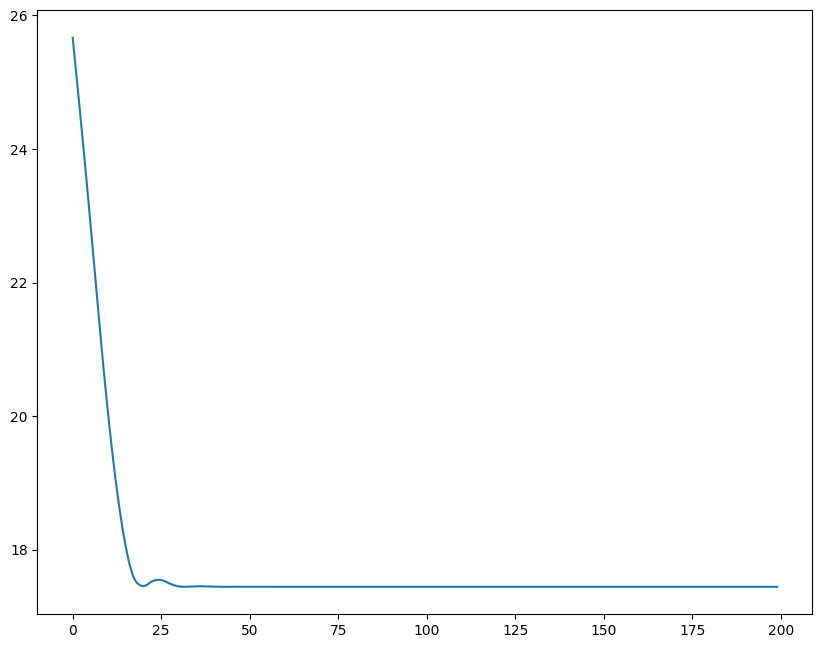

In [13]:
pyplot.figure(figsize=(10,8), dpi = 100).set_facecolor("white")
pyplot.plot(losses)

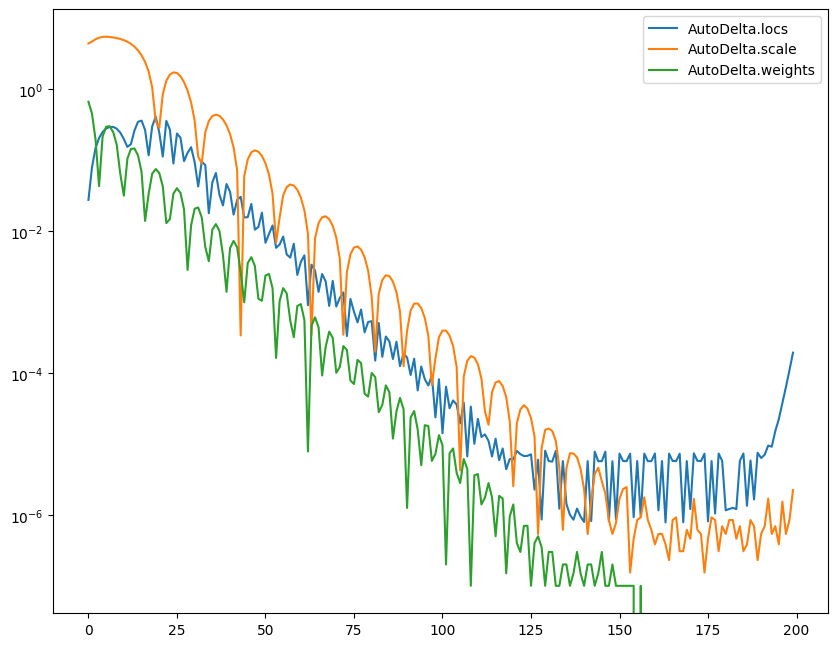

In [14]:
pyplot.figure(figsize=(10,8), dpi = 100).set_facecolor("white")
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.yscale('log')
pyplot.legend(loc='best')

In [15]:
map_estimates = global_guide(data)

In [16]:
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']

In [ ]:
scale

In [17]:
X =  np.arange(-3, 15, 0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X-locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X-locs[1].item()) / scale.item())

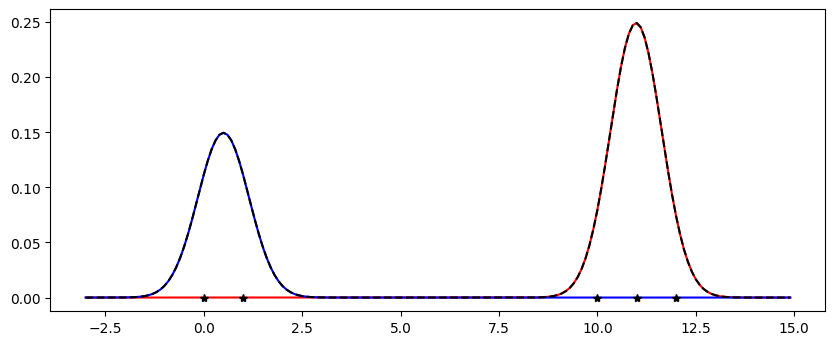

In [18]:
pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')

### Finally note that optimization with mixture models is non-convex and can often get stuck in local optima. For example in this tutorial, we observed that the mixture model gets stuck in an everthing-in-one-cluster hypothesis if scale is initialized to be too large.

## [Serving the model: predicting membership](http://pyro.ai/examples/gmm.html#Serving-the-model:-predicting-membership)

#### Now that we’ve trained a mixture model, we might want to use the model as a classifier. During training we marginalized out the assignment variables in the model. While this provides fast convergence, it prevents us from reading the cluster assignments from the guide. We’ll discuss two options for treating the model as a classifier: first using infer_discrete (much faster) and second by training a secondary guide using enumeration inside SVI (slower but more general).

### Predicting membership using discrete inference

In [19]:
# record the globals
guide_trace = poutine.trace(global_guide).get_trace(data)
# replay the model
trained_model = poutine.replay(model, trace=guide_trace)

In [20]:
inferred_model = infer_discrete(trained_model, temperature=0, first_available_dim=-2) # avoid conflicting with data palte -1
trace = poutine.trace(inferred_model).get_trace(data)
trace.nodes['assignment']['value']


tensor([1, 1, 0, 0, 0])

In [21]:
def classify(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=0, first_available_dim=-2) # avoid conflicting with data palte -1
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes['assignment']['value']

In [22]:
new_data = torch.arange(-3, 15, 0.1)

In [23]:
assignment = classify(new_data)

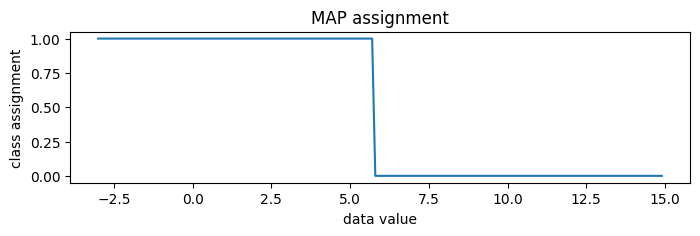

In [24]:
pyplot.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
pyplot.plot(new_data.numpy(), assignment.numpy())
pyplot.title('MAP assignment')
pyplot.xlabel('data value')
pyplot.ylabel('class assignment');

### To generate random posterior assignments rather than MAP assignments, we could set

In [25]:
classify(data, temperature=1)

tensor([1, 1, 0, 0, 0])

/tmp/ipykernel_318/3428731520.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx" (-> color='b'). The keyword argument will take precedence.
  pyplot.plot(new_data.numpy(), assignment.numpy(), 'bx', color='C0')


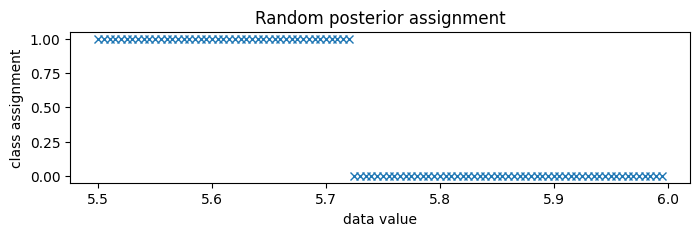

In [26]:
new_data = torch.arange(5.5, 6.0, 0.005)
assignment = classify(new_data, temperature=1)
pyplot.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
pyplot.plot(new_data.numpy(), assignment.numpy(), 'bx', color='C0')
pyplot.title('Random posterior assignment')
pyplot.xlabel('data value')
pyplot.ylabel('class assignment');

### [Predicting membership by enumerating in the guide](http://pyro.ai/examples/gmm.html#Predicting-membership-by-enumerating-in-the-guide)

##### A second way to predict class membership is to enumerate in the guide. This doesn’t work well for serving classifier models, since we need to run stochastic optimization for each new input data batch, but it is more general in that it can be embedded in larger variational models.

##### To read cluster assignments from the guide, we’ll define a new full_guide that fits both global parameters (as above) and local parameters (which were previously marginalized out). Since we’ve already learned good values for the global variables, we will block SVI from updating those by using poutine.block.

In [28]:
@config_enumerate
def full_guide(data):
    with poutine.block(hide_types=["param"]): # keep learned values of global parameters untouched
        global_guide(data)
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K, 
                                                            constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

In [29]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, full_guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [30]:
losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

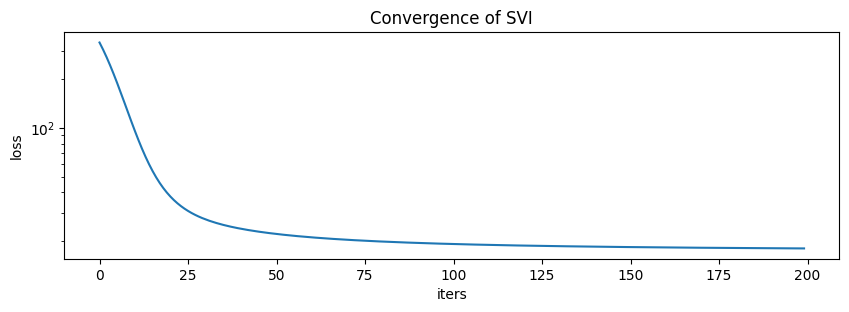

In [31]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

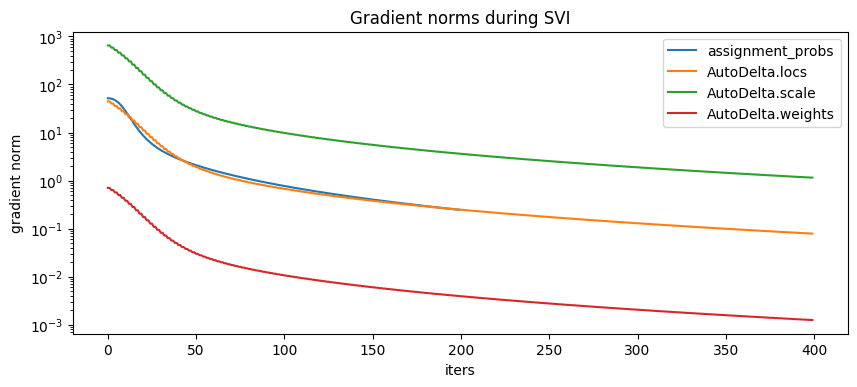

In [32]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [33]:
assignment_probs = pyro.param('assignment_probs')

In [34]:
assignment_probs

tensor([[8.3707e-04, 9.5098e-01],
        [8.4354e-04, 9.5089e-01],
        [9.5084e-01, 8.4742e-04],
        [9.5094e-01, 8.3962e-04],
        [9.5101e-01, 8.3439e-04]], grad_fn=<ClampBackward1>)

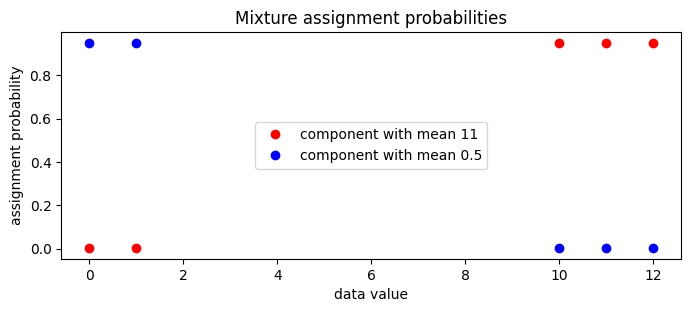

In [35]:
pyplot.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 0], 'ro',
            label='component with mean {:0.2g}'.format(locs[0]))
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 1], 'bo',
            label='component with mean {:0.2g}'.format(locs[1]))
pyplot.title('Mixture assignment probabilities')
pyplot.xlabel('data value')
pyplot.ylabel('assignment probability')
pyplot.legend(loc='center')

### [MCMC](http://pyro.ai/examples/gmm.html#MCMC)